<a href="https://colab.research.google.com/github/stefsyrsiri/synthetic-image-detection/blob/anna/report.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Detecting AI-Generated Synthetic Images

The boom of AI-powered content generation and increasing interest in the research field of Deep Learning has led to widely accessible (and trending) tools that can produce content of any kind: text, image, audio, and video. This high GenAI trend has even led to the advancedment of existing tools, that had been forgotten. AI-generated content can often be indistinguishable from its authentic counterparts, posing a threat to the credibility of digital media. The underlying dangers of the misuse of GenAI have already come to surface with deepfakes, voice cloning, fakes news, disinformation, identity theft and various types of scams.

In this report, we focus on image generation, which can have multiple societal effects, especially on people not familiar with this kind of technology. Our task is to train a neural network to identify whether an image is real or AI-generated.



In [ ]:
# Project overview
# TO-DO: Add statistics from credible sources / read papers
# TO-DO: Find media to add / Try to find high-res images from the dataset
# 1. CNN
# 2. Transfer learning
# 3. Demo

In [30]:
# Import packages and custom functions
# Data Handling
import os
import sys
from PIL import Image
import time
import pandas as pd
import numpy as np
import tempfile


# PyTorch and CV
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import DataLoader
from torch.utils.data import random_split
from torchvision import datasets, transforms, models
from torchvision.transforms import InterpolationMode, v2
import torchvision.transforms.v2 as v2_transforms
import cv2


# Visualization and Evaluation
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.manifold import TSNE

# Classes
!git clone https://github.com/stefsyrsiri/synthetic-image-detection.git
sys.path.append('/content/synthetic-image-detection')
from functions import *
from testpy import test
test

#TO-DO: Do we need the following?
# import tensorflow
# from tensorflow.keras import Model #Model class for instantiating the ResNet that you will be creating.


# #These are all described in standard deep learning literature (e.g. Conv2Dor Dense). Why they are necessary can be found in the He et al. (2016) paper.
# from tensorflow.keras.layers import Add, GlobalAveragePooling2D,\
# Dense, Flatten, Conv2D, Lambda, Input, BatchNormalization, Activation schedules and the Stochastic Gradient Descent optimizer for optimization purposes.
# from tensorflow.keras.optimizers import schedules, SGD

# For visualizing your training results and saving your model, respectively.
# from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint


fatal: destination path 'synthetic-image-detection' already exists and is not an empty directory.


'>>^ω^<<'

## Dataset

The dataset we're using to train our classifier is **[CIFAKE: Real and AI-Generated Synthetic Images](https://www.kaggle.com/datasets/birdy654/cifake-real-and-ai-generated-synthetic-images)**, which can be found on Kaggle.

CIFAKE is a comprehensive collection of 60,000 synthetically-generated images and 60,000 real images (collected from CIFAR-10). The dataset contains two classes, labelled as "REAL" and "FAKE".

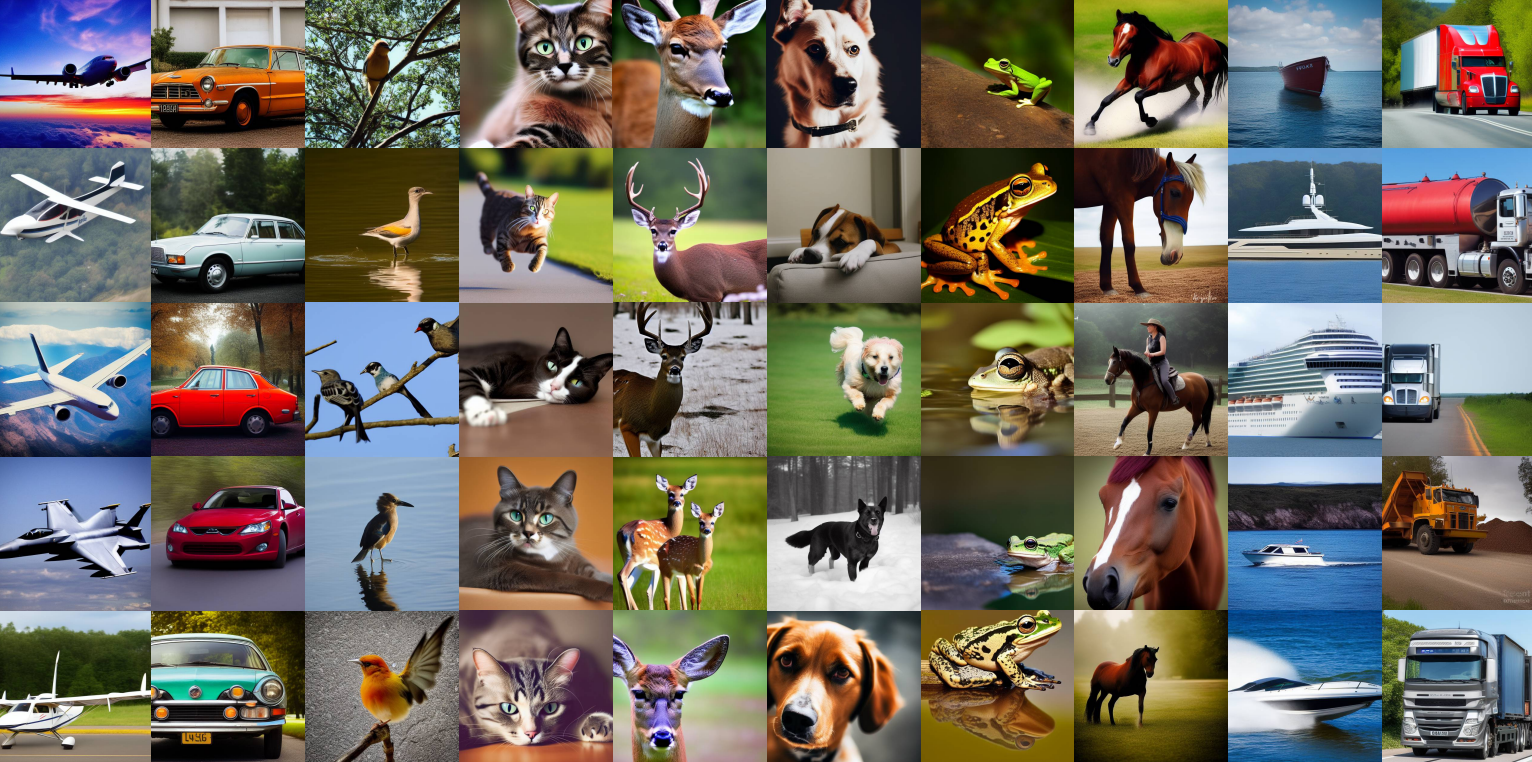

In [4]:
# The dataset exceeds Github's limits and needs to be downloaded directly from Kaggle
# Download CIFAKE dataset
!kaggle datasets download -d birdy654/cifake-real-and-ai-generated-synthetic-images

# Unzip downloaded dataset (can be found in the Files on the left)
!unzip -q cifake-real-and-ai-generated-synthetic-images.zip

Dataset URL: https://www.kaggle.com/datasets/birdy654/cifake-real-and-ai-generated-synthetic-images
License(s): other
 98% 102M/105M [00:03<00:00, 35.1MB/s] 
100% 105M/105M [00:03<00:00, 33.2MB/s]


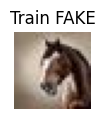

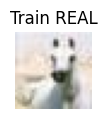

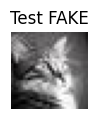

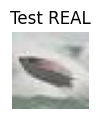

In [31]:
# Paths to the dataset
train_fake_path = './train/FAKE'
train_real_path = './train/REAL'
test_fake_path = './test/FAKE'
test_real_path = './test/REAL'

# Function to display an image
def show_image(title, path):
    image_files = os.listdir(path)
    img_path = os.path.join(path, image_files[6])  # Just take the first image for now
    img = Image.open(img_path)

    plt.figure(figsize=(1, 1))
    plt.imshow(img)
    plt.title(title)
    plt.axis('off')  # Hide the axis
    plt.show()

# TO-DO: Display the images nicely
# Show one image from each category
show_image('Train FAKE', train_fake_path)
show_image('Train REAL', train_real_path)
show_image('Test FAKE', test_fake_path)
show_image('Test REAL', test_real_path)

In [32]:
# Our classes' labels
print(f"Training labels: {np.asarray(os.listdir('train'))}")
print(f"Test labels: {np.asarray(os.listdir('test'))}")

Training labels: ['REAL' 'FAKE']
Test labels: ['REAL' 'FAKE']


In [33]:
# Create the training and test datasets with ImageFolder class from PyTorch
# Training set
train_set = datasets.ImageFolder(root='train') # 'train' is the name of the folder (also its path)
print(f"Training set: {len(train_set):,}")

# Test set
test_set  = datasets.ImageFolder(root='test')
print(f"Test set: {len(test_set):,}")

Training set: 100,000
Test set: 20,000


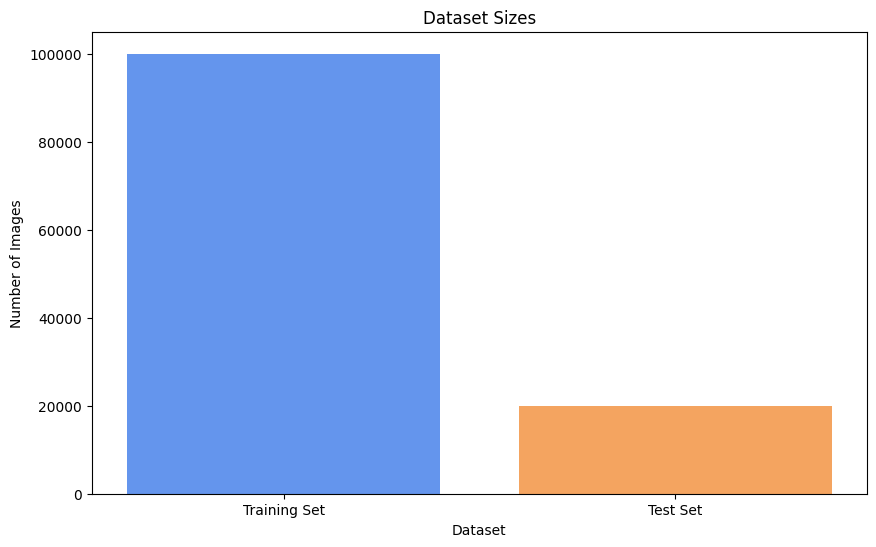

In [ ]:
# Plot graphs showing the sizes of the training and test sets
dataset_sizes = [len(train_set), len(test_set)]
dataset_labels = ['Training Set', 'Test Set']

plt.figure(figsize=(10, 6))
plt.bar(dataset_labels, dataset_sizes, color=['cornflowerblue', 'sandybrown'])
plt.xlabel('Dataset')
plt.ylabel('Number of Images')
plt.title('Dataset Sizes')
plt.show()

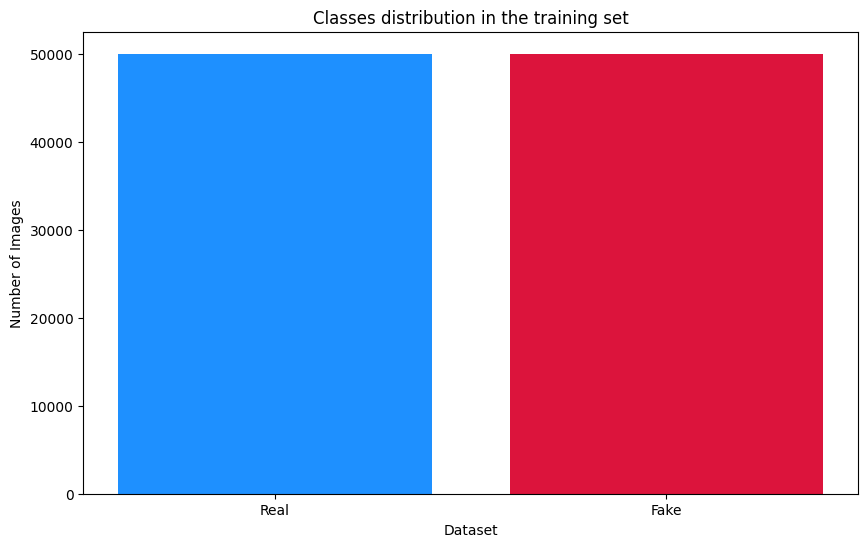

In [ ]:
# Observe the number of images for each class in testset
real_count_train = sum(label == 0 for label in train_set.targets)
fake_count_train = sum(label == 1 for label in train_set.targets)

# Define labels and counts
train_set_labels = ['Real', 'Fake']
train_counts = [real_count_train, fake_count_train]

plt.figure(figsize=(10, 6))
plt.bar(train_set_labels, train_counts, color=['dodgerblue', 'crimson'])
plt.xlabel('Dataset')
plt.ylabel('Number of Images')
plt.title('Classes distribution in the training set')
plt.show()

Applying transformations and visualizing them helps ensure that the data preprocessing and augmentation pipeline is correctly implemented before we start the training.
It also ensures that the transformations are enhancing the dataset in a way that will help the model generalize better to new / unseen data,
ultimately improving the model's performance and ensuring robustness.

We further split the training set into 80/20 training and validation sets.

### Data split

In [34]:
len_img=len(train_set)
len_train=int(0.8*len_img)
len_val=len_img-len_train

# Split Pytorch tensor
train_set,val_set=random_split(train_set,
                             [len_train,len_val]) # random split 80/20

print(f"Training set size: {len(train_set):,}")
print(f"Validation set size: {len(val_set):,}")
# TO-DO: Another graph now that we have a val set as well

Training set size: 80,000
Validation set size: 20,000


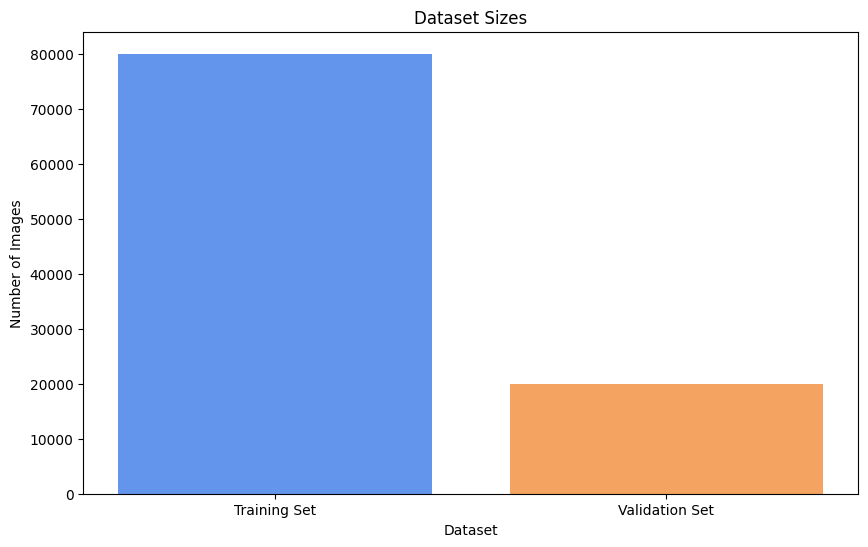

In [ ]:
# Plot graphs showing the sizes of the training and test sets
dataset_sizes = [len(train_set), len(val_set)]
dataset_labels = ['Training Set', 'Validation Set']

plt.figure(figsize=(10, 6))
plt.bar(dataset_labels, dataset_sizes, color=['cornflowerblue', 'sandybrown'])
plt.xlabel('Dataset')
plt.ylabel('Number of Images')
plt.title('Dataset Sizes')
plt.show()

In [53]:

def transform_set(set_type: str):
    """
    This function applies image transformations based on the dataset type and using predefined parameters.

        Args:
            set_type (str): The type of dataset for which transformations are applied.
                training: Applies random horizontal flip, rotation, color jitter, random channel permutation and resized crop for data augmentation (predefined parameters).
                validation: Applies normalization for preparing the data.

        Returns:
            torchvision.transforms.Compose: A composed transformation object.
    """
    from torchvision import transforms
    from torchvision.transforms import InterpolationMode, v2

    # Preprocessing for a training set
    if set_type == "training":
        transformation = transforms.Compose([
            transforms.Resize(size=(224, 224), interpolation=InterpolationMode.BILINEAR, antialias=True),
            transforms.CenterCrop(224),

            # Data augmentation
             transforms.RandomHorizontalFlip(p=0.5),
             transforms.ColorJitter(brightness=.3, contrast = 0.3),
             transforms.RandomRotation(30),
             transforms.RandomResizedCrop(32, scale=(0.8, 1.0)),
             v2.RandomChannelPermutation(),
             transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
        ])

    #Preprocessing without data augmentation (suitable for validation sets)
    elif set_type == "validation":
        transformation = transforms.Compose([
             transforms.Resize(size=(224, 224), interpolation=InterpolationMode.BILINEAR, antialias=True),
            # transforms.CenterCrop(224),
            transforms.ToTensor(),
            # transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
        ])

    return transformation

### Preprocessing

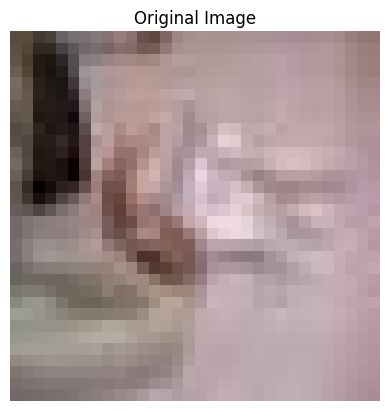

In [10]:
img, label = val_set[3] # TO-DO: Can we pick the image of a cat?

# Convert PIL Image to numpy array
img_np = np.array(img)

# Visualize the original image
plt.imshow(img_np)
plt.axis('off')
plt.title("Original Image")
plt.show()

In [54]:
# Transform the training and validation sets
train_set.dataset.transform = transform_set(set_type='training')
val_set.dataset.transform = transform_set(set_type='validation')

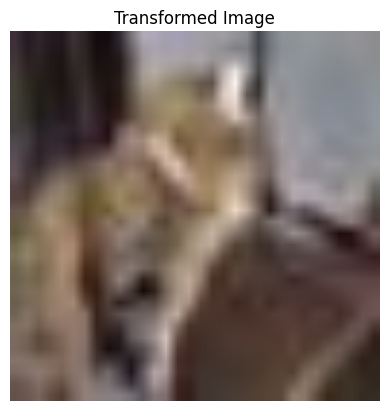

In [55]:

# Get an image and label from the validation set
img, label = val_set[3]

 #Ensure 'img' is a PIL image for the transformation to work
img = transforms.ToPILImage()(img)
val_transformed_img = transform_set(set_type='validation')(img)

# Convert the transformed image from PyTorch tensor to NumPy array
val_transformed_img_np = val_transformed_img.permute(1, 2, 0).numpy()

# # Denormalize the image for visualization
# mean = np.array([0.5, 0.5, 0.5])
# std = np.array([0.5, 0.5, 0.5])
# val_transformed_img_np = std * val_transformed_img_np + mean
# val_transformed_img_np = np.clip(val_transformed_img_np, 0, 1)

# Visualize the transformed image
plt.imshow(val_transformed_img_np)
plt.axis('off')
plt.title("Transformed Image")
plt.show()

Augmentation techniques (e.g. random rotations, flips, color jittering) are typically applied only to the training set. The purpose of data augmentation is to artificially expand the training set and help the model generalize better by learning from varied examples. In other words, we don't want our model to fixate on irrelevant features like orientation, but capture the important ones instead. Augmentation should not be applied to the validation set because it should represent the true distribution of data the model will encounter in real-world scenarios.
:

*   Resize: all images have a uniform size, which is required for batch processing in neural networks     
*   Center crop: ensuring that the center of the image is retained. This is a common practice to standardize input sizes for models like those in the ResNet family.

Data augmentation
*   Random horizontal flip: Flips the image horizontally with a probability of 0.5. This helps the model become invariant to the horizontal orientation of objects, increasing its robustness.
*   Random rotation: Rotates the image by up to 30 degrees randomly. This adds variation to the dataset, helping the model learn to recognize objects from different angles.
*   Color jitter: Randomly changes the brightness and contrast of the image, simulating different lighting conditions. This makes the model more robust to changes in lighting in real-world scenarios.
*   Random channel permutation: Randomly permutes the RGB channels, which can help the model become invariant to color variations. This is especially useful if color is not a crucial feature for classification.
*   Normalization: For each channel using the specified mean and standard deviation.
*  Random Resized Crop: This transformation is useful in data augmentation for tasks like image classification, where it introduces variations in the training data by randomly cropping and resizing images.Randomly crop a section of the image where the area of the crop varies between 80% and 100% of the original image's area.The cropped section is resized to a size of 32x32 pixels after cropping.


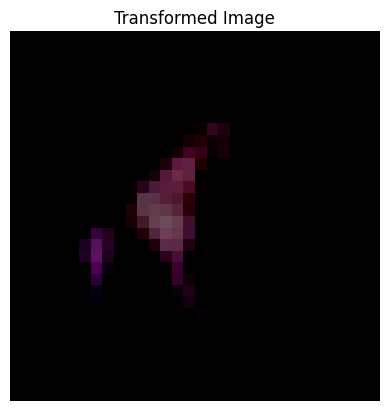

In [56]:
img, label = train_set[3]

train_transformed_img = transform_set(set_type='training')


 #Ensure 'img' is a PIL image for the transformation to work
img = transforms.ToPILImage()(img)

Train_transformed_img = transform_set(set_type='training')(img)

# Convert the transformed image from PyTorch tensor to NumPy array
Train_transformed_img_np = Train_transformed_img.permute(1, 2, 0).numpy()

# # Denormalize the image for visualization
# mean = np.array([0.5, 0.5, 0.5])
# std = np.array([0.5, 0.5, 0.5])
# Train_transformed_img_np = std * Train_transformed_img_np + mean
# Train_transformed_img_np = np.clip(Train_transformed_img_np, 0, 1)

# Visualize the transformed image
plt.imshow(Train_transformed_img_np)
plt.axis('off')
plt.title("Transformed Image")
plt.show()


In [57]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


## Training

For the training we opted for 16 batches and shuffled the training and validation sets, without touching the test set.

In [58]:
# Batch size - change if we get an Out Of Memory error
batch_size = 64

# Training data loaders
train_loader = DataLoader(
    train_set, batch_size=batch_size, shuffle=True, # Shuffle for every epoch
    num_workers=2, pin_memory=True # Changed num_workers to 2 from 4 after warning
)
# Validation data loaders
val_loader = DataLoader(
    val_set, batch_size=batch_size, shuffle=False, # No need to shuffle the validation set
    num_workers=2, pin_memory=True
)

# Test data loaders
test_loader = DataLoader(
    test_set, batch_size=batch_size, shuffle=False, # No need to shuffle the test set
    num_workers=2, pin_memory=True
)

### Neural network architecture

(add media)

We built our classifier with three convolutions layers (conv1, conv2, conv3) ending with 128 output channels, with ReLU activation functions, followed by max pooling layers (pool) and dropout. The fully connected layers (fc1, fc2, and fc3) process the output of the convolutional layers. We chose a kernel size of 3 and 1 padding.
We use Binary Cross Entropy loss which is appropriate for binary classification tasks like this one.

In [59]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import accuracy_score, f1_score
import matplotlib.pyplot as plt
import time

def train_model(model, train_loader, val_loader, n_epochs=20, learning_rate=0.001, patience=5):
    train_losses, val_losses, train_accuracies, val_accuracies, train_f1s, val_f1s = [], [], [], [], [], []

    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    # Check if GPU is available and move the model to GPU
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3)
    best_val_loss = float('inf')
    patience_counter = 0
    best_model_params = model.state_dict()


    since = time.time()

    # Training loop
    for epoch in range(n_epochs):
        model.train()
        train_loss = 0.0
        train_acc = 0.0
        train_f1 = 0.0
        total_train_batches = len(train_loader)

        for train_images, train_labels in train_loader:
            train_images, train_labels = train_images.to(device), train_labels.to(device)
            optimizer.zero_grad()
            outputs = model(train_images)
            train_labels = train_labels.view(-1, 1).float()
            loss = criterion(outputs, train_labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            predictions = (outputs > 0.5).float()
            train_acc += accuracy_score(train_labels.cpu().numpy(), predictions.cpu().numpy())
            train_f1 += f1_score(train_labels.cpu().numpy(), predictions.cpu().numpy(), average='macro')

        avg_train_loss = train_loss / total_train_batches
        avg_train_acc = train_acc / total_train_batches
        avg_train_f1 = train_f1 / total_train_batches

        train_losses.append(avg_train_loss)
        train_accuracies.append(avg_train_acc)
        train_f1s.append(avg_train_f1)

        # Validation step
        model.eval()
        val_loss = 0.0
        val_acc = 0.0
        val_f1 = 0.0
        total_val_batches = len(val_loader)

        with torch.no_grad():
            for val_images, val_labels in val_loader:
                val_images, val_labels = val_images.to(device), val_labels.to(device)
                outputs = model(val_images)
                val_labels = val_labels.view(-1, 1).float()
                loss = criterion(outputs, val_labels)
                val_loss += loss.item()

                predictions = (outputs > 0.5).float()
                val_acc += accuracy_score(val_labels.cpu().numpy(), predictions.cpu().numpy())
                val_f1 += f1_score(val_labels.cpu().numpy(), predictions.cpu().numpy(), average='macro')

        avg_val_loss = val_loss / total_val_batches
        avg_val_acc = val_acc / total_val_batches
        avg_val_f1 = val_f1 / total_val_batches

        val_losses.append(avg_val_loss)
        val_accuracies.append(avg_val_acc)
        val_f1s.append(avg_val_f1)

# Print learning rate
        current_lr = optimizer.param_groups[0]['lr']

        print(
              f'Epoch [{epoch+1}/{n_epochs}] - '
              f'Learning Rate: {optimizer.param_groups[0]["lr"]:.6f}  '
              f'Training Loss: {avg_train_loss:.4f}, '
              f'Validation Loss: {avg_val_loss:.4f}, '
              f'Training Accuracy: {avg_train_acc:.4f}, '
              f'Validation Accuracy: {avg_val_acc:.4f}, '
              f'Training F1: {avg_train_f1:.4f}, '
              f'Validation F1: {avg_val_f1:.4f}')

         #Adjust learning rate based on validation loss
        scheduler.step(avg_val_loss)

        # Early stopping based on validation loss
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            patience_counter = 0
            # Update the best model parameters
            best_model_params = model.state_dict()
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f'Early stopping after {epoch+1} epochs.')
                break

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best Validation loss: {best_val_loss:.4f}')

    # Load the best model parameters
    model.load_state_dict(best_model_params)

    # Plotting training progress
    plt.figure(figsize=(10, 8))

    # Plotting Loss
    plt.subplot(2, 1, 1)
    plt.plot(range(epoch+1), train_losses, '--', label='Training Loss')
    plt.plot(range(epoch+1), val_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()

    # Plotting F1-score
    plt.subplot(2, 1, 2)
    plt.plot(range(epoch+1), train_f1s, '--', label='Training F1-score')
    plt.plot(range(epoch+1), val_f1s, label='Validation F1-score')
    plt.xlabel('Epochs')
    plt.ylabel('F1-score')
    plt.title('Training and Validation F1-score')
    plt.legend()

    plt.tight_layout()
    plt.show()



Epoch [1/20] - Learning Rate: 0.001000Training Loss: 0.3671, Validation Loss: 0.2804, Training Accuracy: 0.8318, Validation Accuracy: 0.8809, Training F1: 0.8277, Validation F1: 0.8787
Epoch [2/20] - Learning Rate: 0.001000Training Loss: 0.2156, Validation Loss: 0.2007, Training Accuracy: 0.9136, Validation Accuracy: 0.9202, Training F1: 0.9122, Validation F1: 0.9189
Epoch [3/20] - Learning Rate: 0.001000Training Loss: 0.1520, Validation Loss: 0.1815, Training Accuracy: 0.9407, Validation Accuracy: 0.9304, Training F1: 0.9398, Validation F1: 0.9292
Epoch [4/20] - Learning Rate: 0.001000Training Loss: 0.1054, Validation Loss: 0.2282, Training Accuracy: 0.9601, Validation Accuracy: 0.9246, Training F1: 0.9595, Validation F1: 0.9235
Epoch [5/20] - Learning Rate: 0.001000Training Loss: 0.0714, Validation Loss: 0.2355, Training Accuracy: 0.9728, Validation Accuracy: 0.9181, Training F1: 0.9724, Validation F1: 0.9166
Epoch [6/20] - Learning Rate: 0.001000Training Loss: 0.0521, Validation Los

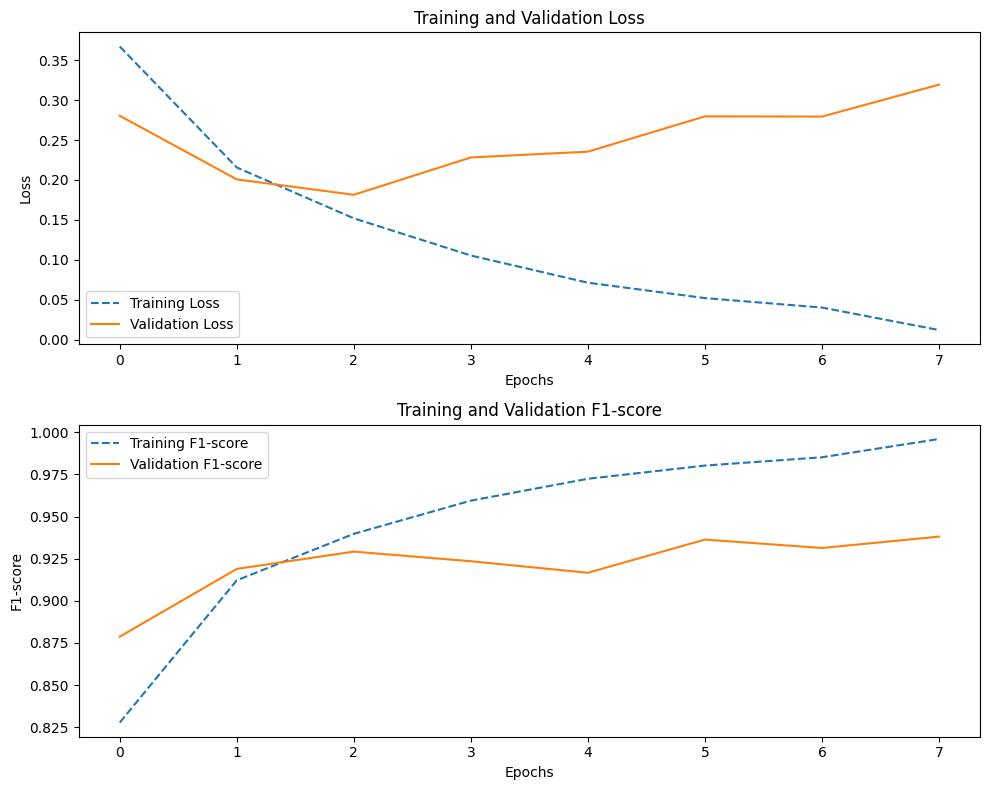

In [60]:
train_model(model=ConvNet(), train_loader=train_loader, val_loader=val_loader)

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Epoch [1/20] - Learning Rate: 0.001000, Training Loss: 0.6979, Validation Loss: 0.6273, Training Accuracy: 0.5400, Validation Accuracy: 0.7500, Training F1: 0.3686, Validation F1: 0.4281
Epoch [2/20] - Learning Rate: 0.001000, Training Loss: 0.6954, Validation Loss: 0.6291, Training Accuracy: 0.5500, Validation Accuracy: 0.7500, Training F1: 0.3905, Validation F1: 0.4281
Epoch [3/20] - Learning Rate: 0.001000, Training Loss: 0.6937, Validation Loss: 0.6319, Training Accuracy: 0.5500, Validation Accuracy: 0.7500, Training F1: 0.3878, Validation F1: 0.4281
Epoch [4/20] - Learning Rate: 0.001000, Training Loss: 0.6924, Validation Loss: 0.6350, Training Accuracy: 0.5500, Validation Accuracy: 0.7500, Training F1: 0.4006, Validation F1: 0.4281
Epoch [5/20] - Learning Rate: 0.001000, Training Loss: 0.6907, Validation Loss: 0.6369, Training Accuracy: 0.5500, Validation Accuracy: 0.7500, Training F1: 0.3906, Validation F1: 0.4281
Epoch [6/20] - Learning Rate: 0.000100, Training Loss: 0.6900, Va

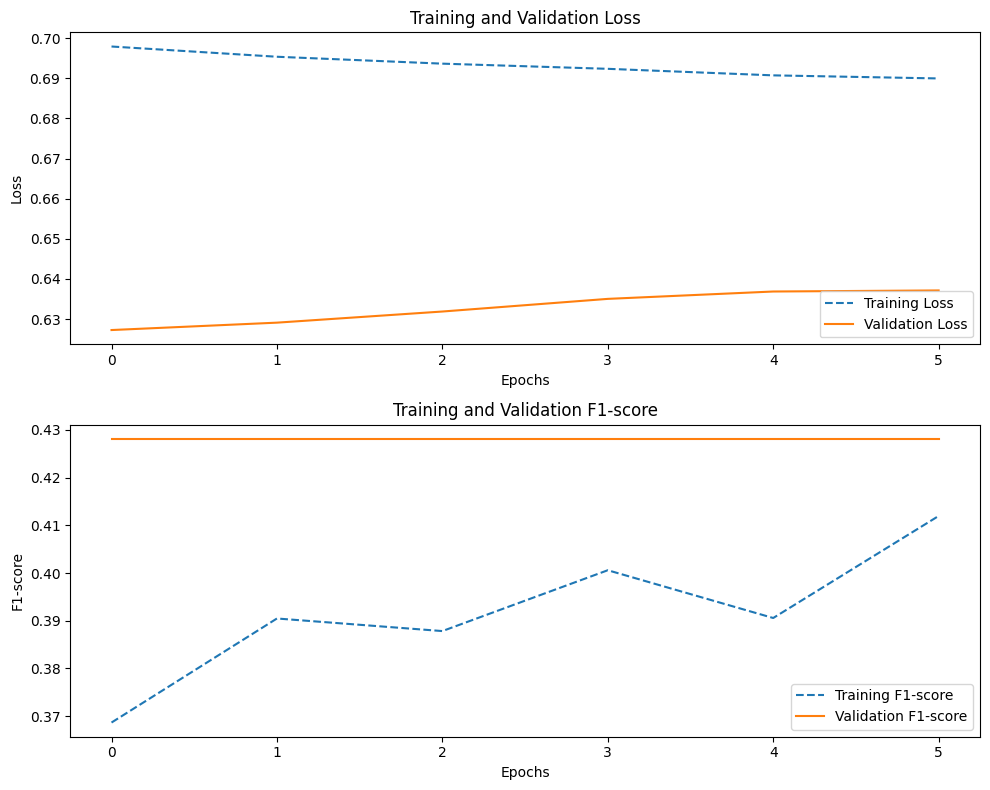

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
import time
from sklearn.metrics import accuracy_score, f1_score

# Define a simple neural network model
class DummyModel(nn.Module):
    def __init__(self):
        super(DummyModel, self).__init__()
        self.fc1 = nn.Linear(10, 5)  # Input size: 10, Output size: 5
        self.fc2 = nn.Linear(5, 1)   # Input size: 5, Output size: 1

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.sigmoid(self.fc2(x))
        return x

# Generate dummy data
x_train = torch.randn(100, 10)  # 100 samples, 10 features
y_train = torch.randint(0, 2, (100, 1)).float()  # Binary labels
x_val = torch.randn(20, 10)  # 20 samples, 10 features
y_val = torch.randint(0, 2, (20, 1)).float()  # Binary labels

# Create DataLoader for training and validation
train_dataset = TensorDataset(x_train, y_train)
val_dataset = TensorDataset(x_val, y_val)

batch_size = 10
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)


# Function to train the model
def train_model(model, train_loader, val_loader, n_epochs=20, learning_rate=0.001, patience=5):
    train_losses, val_losses, train_accuracies, val_accuracies, train_f1s, val_f1s = [], [], [], [], [], []

    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3, verbose=True)
    best_val_loss = float('inf')
    patience_counter = 0
    best_model_params = model.state_dict()

    since = time.time()

    # Training loop
    for epoch in range(n_epochs):
        model.train()
        train_loss = 0.0
        train_acc = 0.0
        train_f1 = 0.0
        total_train_batches = len(train_loader)

        for train_images, train_labels in train_loader:
            train_images, train_labels = train_images.to(device), train_labels.to(device)
            optimizer.zero_grad()
            outputs = model(train_images)
            train_labels = train_labels.view(-1, 1).float()
            loss = criterion(outputs, train_labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            predictions = (outputs > 0.5).float()
            train_acc += accuracy_score(train_labels.cpu().numpy(), predictions.cpu().numpy())
            train_f1 += f1_score(train_labels.cpu().numpy(), predictions.cpu().numpy(), average='macro')

        avg_train_loss = train_loss / total_train_batches
        avg_train_acc = train_acc / total_train_batches
        avg_train_f1 = train_f1 / total_train_batches

        train_losses.append(avg_train_loss)
        train_accuracies.append(avg_train_acc)
        train_f1s.append(avg_train_f1)

        # Validation step
        model.eval()
        val_loss = 0.0
        val_acc = 0.0
        val_f1 = 0.0
        total_val_batches = len(val_loader)

        with torch.no_grad():
            for val_images, val_labels in val_loader:
                val_images, val_labels = val_images.to(device), val_labels.to(device)
                outputs = model(val_images)
                val_labels = val_labels.view(-1, 1).float()
                loss = criterion(outputs, val_labels)
                val_loss += loss.item()

                predictions = (outputs > 0.5).float()
                val_acc += accuracy_score(val_labels.cpu().numpy(), predictions.cpu().numpy())
                val_f1 += f1_score(val_labels.cpu().numpy(), predictions.cpu().numpy(), average='macro')

        avg_val_loss = val_loss / total_val_batches
        avg_val_acc = val_acc / total_val_batches
        avg_val_f1 = val_f1 / total_val_batches

        val_losses.append(avg_val_loss)
        val_accuracies.append(avg_val_acc)
        val_f1s.append(avg_val_f1)

        # Print learning rate
        current_lr = optimizer.param_groups[0]['lr']
        print(f'Epoch [{epoch+1}/{n_epochs}] - Learning Rate: {current_lr:.6f}, '
              f'Training Loss: {avg_train_loss:.4f}, '
              f'Validation Loss: {avg_val_loss:.4f}, '
              f'Training Accuracy: {avg_train_acc:.4f}, '
              f'Validation Accuracy: {avg_val_acc:.4f}, '
              f'Training F1: {avg_train_f1:.4f}, '
              f'Validation F1: {avg_val_f1:.4f}')

        # Adjust learning rate based on validation loss
        scheduler.step(avg_val_loss)

        # Early stopping based on validation loss
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            patience_counter = 0
            best_model_params = model.state_dict()
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f'Early stopping after {epoch+1} epochs.')
                break

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best Validation loss: {best_val_loss:.4f}')

    # Load the best model parameters
    model.load_state_dict(best_model_params)

    # Plotting training progress
    plt.figure(figsize=(10, 8))

    # Plotting Loss
    plt.subplot(2, 1, 1)
    plt.plot(range(epoch+1), train_losses, '--', label='Training Loss')
    plt.plot(range(epoch+1), val_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()

    # Plotting F1-score
    plt.subplot(2, 1, 2)
    plt.plot(range(epoch+1), train_f1s, '--', label='Training F1-score')
    plt.plot(range(epoch+1), val_f1s, label='Validation F1-score')
    plt.xlabel('Epochs')
    plt.ylabel('F1-score')
    plt.title('Training and Validation F1-score')
    plt.legend()

    plt.tight_layout()
    plt.show()

    return model

# Instantiate the dummy model and train it
dummy_model = DummyModel()
trained_model = train_model(dummy_model, train_loader, val_loader, n_epochs=20, patience=5)


In [ ]:
# predictions = (outputs > 0.5).float()  # Thresholding at 0.5 for sigmoid output
# correct = torch.eq(predictions, labels).float().mean()
# accuracy = correct * 100  # Calculate percentage accuracy
# from sklearn.metrics import f1_score
# f1 = f1_score(labels.cpu().numpy(), predictions.cpu().numpy()) * 100
# print(f"Accuracy: {accuracy:.2f}%\nF1: {f1:.2f}%")

Total Iterations per Epoch:Given the training set size of 80,000 and a batch size of 64, the total number of iterations (mini-batches) per epoch is:

total_iterations = total_samples / batch_Size =
80000/64 = 1250
​

Printing Frequency:

You want to balance between too frequent and too infrequent logging. If you print too often, it might clutter the output and slightly slow down training due to I/O operations. If you print too infrequently, you might not get enough information to monitor training effectively.
A common approach is to print the running loss a few times per epoch.

For an 80,000-sample training set and a batch size of 64, a good approach could be to print the loss every 200 mini-batches. This way, you'll get around 6 updates per epoch (1250 iterations / 200 = 6.25), which provides a good balance between feedback frequency and performance overhead.

## Transfer learning

In [ ]:
model_conv = models.resnet18(weights='IMAGENET1K_V1')
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)

model_conv = model_conv.to(device)

In [ ]:
train_model(model=model_conv, train_loader=train_loader, val_loader=val_loader, num_epochs=25)